## Prva domaća zadaća, Matematički softver, PMF-MO, Zagreb

# *Usporedba K-Means i K-Harmonic Means algoritama*

Jedan od popularnijih algoritama u strojnom učenju za *data clustering* (grupiranje podataka) je *K-Means algoritam* (KM), a jedan od popularnijih (ako ne i najpopularniji) programskih jezika u strojnom učenju je Python, stoga ova Jupyter bilježnica dolazi kao savršen pomoćni alat za analizu K-Meansa. Analizu proširujemo i na inačicu K-Means algoritma, pod nazivom *K-Harmonic Means algoritam* (KHM) te ćemo usporediti ponašanje ta dva algoritma nad istim skupom podataka.

Dijelovi bilježnice:
1. [Uvod](#uvod) - *ukratko o center-based algoritmima*
2. [Opći model iterativnog algoritma](#model) - *uvođenje glavnih pojmova i koraka algoritama*
    1. [Skup podataka X](#x)
    2. [Skup centara C](#c)
    3. [Koraci općeg modela algoritma](#koraci)
3. [K-Means algoritam](#km) - *implementacija pojmova uvedenih u 2. poglavlju*
4. [K-Harmonic Means algoritam](#khm) - *implementacija pojmova uvedenih u 2. poglavlju*
5. [Testiranje](#testiranje) - *pokretanje algoritama i uspoređivanje rezultata*
    1. [K-Means & Forgy](#kmf)
    2. [K-Harmonic Means & Forgy](#khmf)
    3. [K-Means & Random Partition](#kmrp)
    4. [K-Harmonic Means & Random Partition](#khmrp)
    5. [Usporedba grafova](#usporedba)
    5. [Prosječno ponašanje algoritama](#prosjecno)
6. [Zaključak](#zakljucak) - *donošenje zaključaka o pojedinim algoritmima i njihovim usporedbama*
7. [Dodatak](#dodatak) - *višedimenzionalne vizualizacije random izgeneriranih skupova podataka*
8. [Literatura](#literatura)

### UVOD <a name="uvod"></a>

Oba algoritma spadaju u skupinu *center-based* algoritama. To su algoritmi koji rade na principu broja centara za reprezentaciju i/ili particiju ulaznih podataka. Svaki centar definira grupu kojoj je on središnja točka. Dakle, rješenje algoritma je skup centara.

Algoritmi započinju s **pokušajem** pogotka rješenja i onda **profinjuju** pozicije centara sve dok ne dođu do lokalnog optimuma. Oba algoritma su linearne složenosti.

Svaki od algoritama ima svoju ***cost function*** (funkciju cilja) koja definira koliko je dobro rješenje, a cilj ju je minimizirati. S obzirom na to da te funkcije ne mogu biti minimizirane direktno, koriste se iterativni algoritmi koji naposljetku konvergiraju prema lokalnom minimumu.

In [1]:
## Svi paketi i neke funkcije koje ce biti potrebne

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fractions
from numpy.random import choice
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d

### OPĆI MODEL ITERATIVNOG ALGORITMA <a name="model"></a>

Definirajmo:
- d-dimenzionalan skup sa n podataka **X = {$x_{1}$, ... , $x_{n}$}** kao skup koji ćemo grupirati (klasterirati)
- d-dimenzionalan skup od k centara/središta **C = {$c_{1}$ , ... , $c_{k}$}** kao rješenje tj. grupiranje koje algoritam treba poboljšati
- ***membership function*** (funkciju članstva) **m($c_{j}$|$x_{i}$)** koja nam daje omjer/udio svake točke $x_{i}$ koja pripada centru $c_{j}$
- ***weight function*** (težinska funkcija) **w($x_{i}$)** opisuje koliko utjecaja točka $x_{i}$ ima u ponovnom određivanju parametara centara u sljedećoj iteraciji
- ***cost function*** (funkcija cilja) definira koliko je dobro rješenje, a cilj ju je minimizirati

###### SKUP PODATAKA X <a name="x"></a>

Za skup X učitavamo tablicu podataka sa web-stranice [University of Eastern Finland](http://cs.joensuu.fi/sipu/datasets/) (G2 sets):

In [2]:
X = pd.read_excel('data.xlsx')
X.tail()

54620    43523  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
2994      NaN      NaN     61242.0         NaN         NaN         NaN
2995  11165.0  59822.0         NaN         NaN         NaN         NaN
2996      NaN      NaN     59102.0         NaN         NaN         NaN
2997      NaN      NaN     59244.0         NaN         NaN         NaN
2998  10002.0  61399.0         NaN         NaN         NaN         NaN

Tablicu treba urediti. Najprije izbacujemo nepotrebne stupce (zadnja četiri):

In [3]:
del X['Unnamed: 3'], X['Unnamed: 4'], X['Unnamed: 5'], X['Unnamed: 2']
X.tail()

54620    43523
2994      NaN      NaN
2995  11165.0  59822.0
2996      NaN      NaN
2997      NaN      NaN
2998  10002.0  61399.0

Preuredimo preostala dva stupca. S obzirom da je prvi redak tablice 'data.xlsx' pretvorbom u *Pandas DataFrame* uzet kao imena stupaca, taj redak ćemo ubaciti na kraj tablice (nije važno gdje je) i zatim promijeniti imena stupaca:

In [4]:
X = X.append({54620: 54620, 43523: 43523}, ignore_index=True)
X.tail()

54620    43523
2995  11165.0  59822.0
2996      NaN      NaN
2997      NaN      NaN
2998  10002.0  61399.0
2999  54620.0  43523.0

In [5]:
X.rename(index=int, columns={54620: "x-koordinata", 43523: "y-koordinata"}, inplace=True)
X.tail()

x-koordinata  y-koordinata
2995       11165.0       59822.0
2996           NaN           NaN
2997           NaN           NaN
2998       10002.0       61399.0
2999       54620.0       43523.0

Naša tablica sadrži *NaN* vrijednosti. Uklonit ćemo sve retke u kojima se u nekoj od ćelija pojavljuje NaN:

In [6]:
X = X[np.isfinite(X['x-koordinata'])]
X = X[np.isfinite(X['y-koordinata'])]
X.tail()

x-koordinata  y-koordinata
2988       11775.0       61142.0
2992       10457.0       58942.0
2995       11165.0       59822.0
2998       10002.0       61399.0
2999       54620.0       43523.0

Sada ćemo resetirati indekse jer su zbog uklanjanja NaN-redaka ostale "rupe":

In [7]:
X.reset_index(drop=True,inplace=True)
X.tail()

x-koordinata  y-koordinata
2733       11775.0       61142.0
2734       10457.0       58942.0
2735       11165.0       59822.0
2736       10002.0       61399.0
2737       54620.0       43523.0

In [8]:
X.shape

(2738, 2)

Zasad smo uredili tablicu, prema onome što smo mogli vidjeti iz ispisa dijelova tablica. Pokušajmo sada dobiti sliku o tome kako izgledaju podaci X analizom tablice opisne statistike i vizualnim prikazom histogramom.

In [9]:
pd.DataFrame({vrsta: X[vrsta]
              for vrsta in ["x-koordinata", "y-koordinata"]}).describe()

x-koordinata  y-koordinata
count   2738.000000   2738.000000
mean   38197.464573  50322.246896
std    15606.112845   7818.528811
min    10002.000000  32064.000000
25%    26095.500000  45018.250000
50%    36475.500000  49937.500000
75%    54132.750000  57767.500000
max    65535.000000  64978.000000

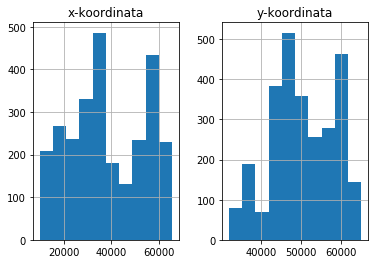

In [10]:
hist = X.hist()

Uočavamo da su koordinate podataka jako velike i da su razlike između najmanjih i najvećih koordinata također jako velike. Provjerimo kako podaci izgledaju na grafu:

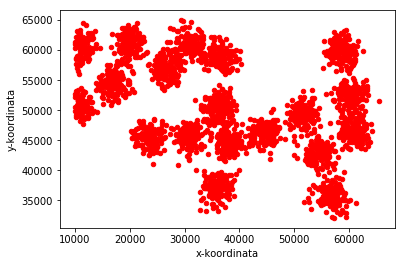

In [11]:
X.plot(kind='scatter', x='x-koordinata', y='y-koordinata', color='red')
plt.show()

Malo kasnije ćemo skalirati ove podatke na manji interval kako bismo uredili ove "ogromnosti". Prije toga ćemo riješiti sljedeći "problem".
Brzina algoritma, naravno, ovisi o veličini ulaznih podataka (N.B. složenosti KM i KHM algoritama su obje linearne) pa tako ovi algoritmi rade malo duže na ovako velikom skupu podataka i s velikim brojem centara. S obzirom da je cilj ove Jupyter bilježnice analizirati neku temu u svrhu upoznavanja s *Jupyter Notebookom*, a ne široka analiza teme K-Means algoritama, reducirat ćemo naš skup podataka kako bi se Jupyter bilježnica brže "kretala". Osim brže Jupyter bilježnice, skaliranjem i reduciranjem broja podataka želimo postići i "ljepše" grafove, tj. uočljiviji i zorniji prikaz rješenja algoritama, tako da čitatelju bilježnice brže upadnu razlike u oko.

Umjesto da nasumično izbacimo podatke i tako možda izgubimo neke prirodne grupacije, izbacit ćemo podatke kako je prikazano na sljedećem grafu:

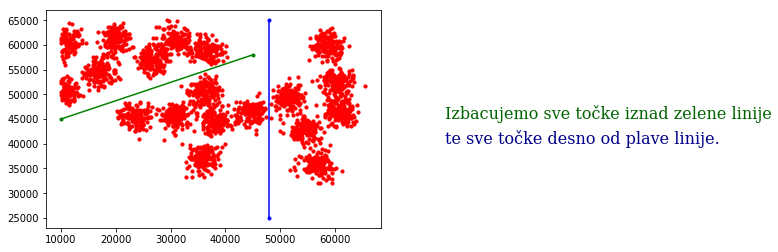

In [12]:
plt.scatter(X['x-koordinata'], X['y-koordinata'], s=10, c='red')
plt.plot([10000,45000], [45000,58000], c= "green", marker='.')
plt.plot([48000,48000], [25000,65000], c= "blue", marker='.')

string1="Izbacujemo sve točke iznad zelene linije"
font1 = {'family': 'serif',
        'color':  'darkgreen',
        'weight': 'normal',
        'size': 16,
        }
string2="te sve točke desno od plave linije."
font2 = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 16,
        }

plt.text(80000,45000,string1,fontdict=font1)
plt.text(80000,40000,string2,fontdict=font2)

plt.show()

Jednadžba pravca zelene linije izgleda ovako:
$$y=\frac{58000-45000}{45000-10000}(x-10000)+45000,$$

a jednadžba pravca plave linije ovako:
$$x=48000$$

I pomoću toga implementiramo sljedeće funkcije:

In [13]:
def iznad_zelenog_pravca(x,y):
    if( y > fractions.Fraction(58000-45000,45000-10000)*(x-10000) + 45000 ):
        return 1
    else:
        return 0
    
def desno_od_plavog_pravca(x,y):
    if( x > 48000 ):
        return 1
    else:
        return 0

In [14]:
indeksi_za_izbaciti = []

for i in range(2738):
    if ( iznad_zelenog_pravca(X.at[i,'x-koordinata'], X.at[i,'y-koordinata']) 
        or desno_od_plavog_pravca(X.at[i,'x-koordinata'], X.at[i,'y-koordinata']) ):
        
        indeksi_za_izbaciti.append(i)
        
len(indeksi_za_izbaciti)

1839

In [15]:
## Pogledajmo velicinu tablice prije izbacivanja ovih podataka
X.shape

(2738, 2)

In [16]:
## Izbacimo sada opisane podatke i ponovno preuredimo indekse

X.drop(X.index[indeksi_za_izbaciti], inplace=True)
X.reset_index(drop=True,inplace=True)


## Pogledajmo velicinu tablice nakon izbacivanja
X.shape

(899, 2)

Text(60000, 40000, 'Super!')

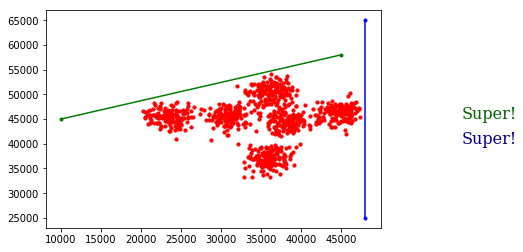

In [17]:
## Provjerimo izgleda li sada nas skup X kako smo planirali

plt.scatter(X['x-koordinata'], X['y-koordinata'], s=10, c='red')
plt.plot([10000,45000], [45000,58000], c= "green", marker='.')
plt.plot([48000,48000], [25000,65000], c= "blue", marker='.')
plt.text(60000,45000,"Super!",fontdict=font1)
plt.text(60000,40000,"Super!",fontdict=font2)

Kako smo i najavili, sada ćemo skalirati naš skup. Podatke iz skupa X ćemo normalizirati Gaussovom, tj. normalnom, razdiobom:

In [18]:
def normalize(X):
    for vrsta in ["x-koordinata", "y-koordinata"]:
        X[vrsta] = ( X[vrsta] - X.mean(axis=0)[vrsta] ) / X.std(axis=0)[vrsta]
    
    return X

In [19]:
X = normalize(X)
X.head()

x-koordinata  y-koordinata
0      1.368974      0.293771
1      1.663915      0.369754
2      1.852042      0.527347
3      1.603007      0.340205
4      1.411580     -0.015317

Za kraj pripreme skupa X, pretočimo naš *Pandas DataFrame* u *Numpy Array* radi jednostavnijeg vektoriziranog baratanja podacima:

In [20]:
X_np = np.array(X)
X_np

array([[ 1.36897352,  0.29377126],
       [ 1.66391532,  0.36975361],
       [ 1.85204198,  0.52734664],
       ...,
       [ 0.14059946, -2.28142084],
       [ 0.18155526, -1.58374335],
       [ 0.16865343, -1.84006654]])

###### SKUP CENTARA C <a name="c"></a>

Sada kada smo uredili skup podataka X, pređimo na skup centara C. Za skup centara C rekli smo da na početku **pogađamo** njihove pozicije, a algoritam ih onda poboljšava. Mi ćemo testirati dva različita načina pogađanja centara, tj. dvije različite inicijalizacije centara: ***Forgy Initialization*** i ***Random Partition Initialization***. Zanima nas pomažu li neki preduvjeti našim algoritmima.

Forgy metoda nasumično odabire k točaka/podataka iz skupa od n zadanih točaka i koristi ih kao početne centre. Random partition metoda dodjeljuje svaku točku iz skupa podataka nasumično odabranoj grupi i potom kao inicijalne/početne centre postavi centroide točaka dodijeljenih određenoj grupi. 

Razlika između ove dvije inicijalizacije je što Forgy raširi sve centre **po skupu podataka**, dok Random Partition sve centre smjesti u malo područje oko središta **svih** točaka/podataka.
Primjer toga vidimo na sljedećoj slici (slika ne prikazuje naš slučaj):

In [21]:
inicijalizacije = plt.imread('forgy-rp.png')
inicijalizacije.shape ## da bismo znali smjestiti tekstualne okvire van dimenzija slike

(254, 644, 3)

Text(410, 320, 'Random Partition')

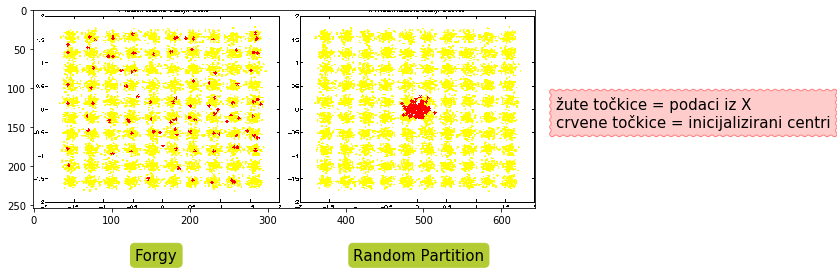

In [22]:
fig,ax = plt.subplots(figsize=(9,9))
ax.imshow(inicijalizacije)

text = "žute točkice = podaci iz X\ncrvene točkice = inicijalizirani centri"

ax.text(670, 150, text, size=15, bbox=dict(boxstyle="roundtooth,pad=0.5", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8) ) )
ax.text(130, 320, "Forgy", size=15, bbox=dict(boxstyle="round", ec=(0.7, 0.8, 0.2), fc=(0.7, 0.8, 0.2) ) )
ax.text(410, 320, "Random Partition", size=15, bbox=dict(boxstyle="round", ec=(0.7, 0.8, 0.2), fc=(0.7, 0.8, 0.2) ) )

Implementirajmo Forgy i RP inicijalizacije:

In [23]:
## 'X' = skup podataka X kojeg grupiramo, 
## 'k' = broj centara koje želimo inicijalizirati (broj grupa koje zelimo konstruirati)

def Forgy_initialization(X,k):
    
    ## Choice ce nam izabrati random k indeksa od n mogucih (random k tocaka iz n mogucih podataka)
    indeksi = choice(np.size(X[:,0]), k, replace=False) # replace=False -> nema ponavljanja indeksa

    forgy_centri = []

    ## Tocke s indeksima dobivenima iz choice-a postavljamo za centre
    for j in range(k):
        forgy_centri.append( X[indeksi[j]] )

    forgy_centri = np.array(forgy_centri)

    return forgy_centri

In [24]:
def RP_initialization(X,k):
    
    ## Choice ce nam izabrati random n indeksa (od k mogucih)
    ## -> za svaku od n tocaka biramo po jedan indeks (indeks grupe kojoj ce pripadati)
    indeksi = choice( k, np.size(X[:,0]) )

    RP_centri = np.zeros((k,2))
    kolicine = np.zeros((k,2))
    
    ## Svaku tocku dodajemo njezinoj grupi 
    ## (jer centar trazimo kao aritmeticku sredinu tih tocaka)
    for i in range( np.size(X[:,0]) ):
        j = indeksi[i]
        RP_centri[j] += X[i]
        kolicine[j] += [1,1]

    ## Ako se dogodilo da nekoj grupi nije dodijeljena nijedna tocka (tj. imamo manje od k grupa)
    ## onda za tu (nepostojecu) grupu odaberi random tocku kao centar
    for j in range(k):
        if( np.array_equal( kolicine[j],[0,0] ) ):
            kolicine[j] = [1,1]
            for i in range(2):
                RP_centri[j,i] = np.random.uniform( np.min(X[:,i]), np.max(X[:,i]) )

    RP_centri = RP_centri / kolicine
    return RP_centri

###### Koraci općeg modela algoritma <a name="koraci"></a>

Nakon uređivanja skupa X i skupa C, pređimo na model samog algoritma.

Svi center-based algoritmi rade po istom općenitom modelu algoritma, a razlikuju se u sljedeće tri funkcije (sve definirane na početku bilježnice): 
- membership function, 
- weight function i 
- cost function.

Koraci općenitog modela iterativnog algoritma:
1. Inicijalizirati algoritam sa „pogođenim“ centrima C.
2. Za svaku točku $x_{i}$, izračunati m($c_{j}$|$x_{i}$) u svakom centru $c_{j}$ i svakoj težini w($x_{i}$).
3. Za svaki centar $c_{j}$, ponovno mu odrediti lokaciju iz svih točaka/podataka $x_{i}$ s obzirom na njihove funkcije članstva i težine:

$$c_{j} = \frac{\sum_{i=1}^n{m(c_{j}|x_{i})w(x_{i})x_{i}}}{\sum_{i=1}^n{m(c_{j}|x_{i})w(x_{i})}}$$
4. Ponavljati korake 2. i 3. dok se ne dođe do konvergencije.

### K-MEANS ALGORITAM <a name="km"></a>

K-Means algoritam particionira podatke u k skupova. Rješenje je skup od k centara, od kojih je svaki centar smješten u središtu svih onih podataka kojima je taj centar najbliži (tj. smješten je u tzv. *centroid* grupe - točka stvorena računanjem aritmetičke sredine za svaku točku u grupi). 

- **Cost function** koju KM algoritam optimizira dana je sa:

$$KM(X,C) = \sum_{i=1}^n{\min_{j\in\{1,...,k\}}\Vert{x_{i}-c_{j}}\Vert^{2}}$$

Ova funkcija cilja daje algoritam koji minimizira varijancu (udaljenost) unutar pojedine grupe.


- **Membership function** i **weight function** dane su sa:

$$m_{KM}(c_{l}|x_{i})= 
\begin{cases}
    1, & l=arg\min_{j\in\{1,...,k\}}\Vert{x_{i}-c_{j}}\Vert^{2}\\
    0, & inače
\end{cases}$$

$$w_{KM}(x_{i})=1$$

KM ima <u>*hard* membership function</u> (jaku funkciju članstva)$^{1}$ i <u>konstantnu weight function</u> koja svim točkama daje jednaku važnost.


$^{1}$*Funkcija članstva je* jaka *ako poprima vrijednosti iz skupa {0,1}.
Funkcija članstva je* slaba (eng. soft) *ako poprima vrijednosti iz segmenta [0,1].*

In [25]:
## Implementacija cost function za KM

def KM(X,C):
    
    suma = 0

    for i in range(np.size(X[:,0])):
        
        ## Za pocetak, za najmanju normu uzmi normu od x[i]-c[0]
        min_norma = np.power( LA.norm(X[i]-C[0]) , 2 )

        ## Sada provjeri postize li se manja norma za neki drugi centar c[j]
        for j in range(1, np.size(C[:,0])):
            pomocni = np.power( LA.norm(X[i]-C[j]) , 2 )
            
            if(pomocni < min_norma):
                min_norma = pomocni

        suma += min_norma

    return suma

In [26]:
## Implementacija membership function za KM

def m_km(C,cj,xi):
    
    ## Za pocetak, kao centar za koji se postize najmanja norma uzmi c[0]
    min_norma = np.power( LA.norm(xi-C[0]) , 2 )
    min_centar = np.array(C[0])

    ## Sada provjeri postize li se manja norma za neki drugi centar c[j]
    for s in range(1,np.size(C[:,0])):
        pomocni = np.power( LA.norm(xi-C[s]) , 2 )
        
        if(pomocni < min_norma):
            min_norma = pomocni
            min_centar = C[s]

    if( np.array_equal( min_centar, cj ) ):
        return 1

    else:
        return 0

In [27]:
## implementacija weight function za KM

def w_km(xi):
    return 1

Implementirajmo još korak 3) za KM iz općeg modela iterativnog algoritma: $c_{j} = \frac{\sum_{i=1}^n{m(c_{j}|x_{i})w(x_{i})x_{i}}}{\sum_{i=1}^n{m(c_{j}|x_{i})w(x_{i})}}$:

In [28]:
def cj_km(X,C,cj):

    brojnik = np.array([0,0])
    nazivnik = 0

    for i in range( np.size(X[:,0]) ):
        pomocni = m_km(C,cj,X[i]) * w_km(X[i])

        brojnik = brojnik + [pomocni,pomocni]*X[i]
        nazivnik += pomocni

    ## Ako je nazivnik=0, onda za centar odaberi neku random tocku u rasponu podataka
    if(nazivnik == 0):
        novi_centar = np.array([0,0])
        novi_centar[0] = np.random.uniform( np.min(X[:,0]), np.max(X[:,1]) )
        novi_centar[1] = np.random.uniform( np.min(X[:,1]), np.max(X[:,1]) )
        return novi_centar

    novi_centar = brojnik / np.array([nazivnik,nazivnik])
    return novi_centar

### K-HARMONIC MEANS ALGORITAM <a name="khm"></a>

K-Harmonic Means algoritam također daje k centara kao svoje rješenje, a razlikuje se od K-Meansa po tome što koristi harmonijsku sredinu:

- **Cost function** K-Harmonic Means algoritma koristi harmonijsku sredinu udaljenosti pojedine točke od svih centara:

$$KHM(X,C) = \sum_{i=1}^n{\frac{k}{\sum_{j=1}^k{\frac{1}{\Vert{x_{i}-c_{j}}\Vert^{p}}}}}$$

- **Membership function** i **weight function** dane su sa:

$$ m_{KHM}(c_{j}|x_{i})=\frac{\Vert{x_{i}-c_{j}}\Vert^{-p-2}}{\sum_{j=1}^k{\Vert{x_{i}-c_{j}}\Vert^{-p-2}}}$$


$$ w_{KHM}(x_{i})=\frac{\sum_{j=1}^k{\Vert{x_{i}-c_{j}}\Vert^{-p-2}}}{(\sum_{j=1}^k{\Vert{x_{i}-c_{j}}\Vert^{-p}})^{2}}$$

Primijetimo da KHM koristi <u>slabu funkciju članstva</u> (eng. *soft membership function*), ali i <u>varirajuću težinsku funkciju</u>. Ova težinska funkcija daje veću težinu točkama čije su udaljenosti od centara velike, što pomaže centrima u širenju kako bi pokrili što veći broj podataka. Dakle, harmonijski red daje bolju (manju) ocjenu onim točkama koje su blizu barem jednom centru. To je inače svojstvo harmonijskog reda; sličan je funkciji cilja KM algoritma, ali je ovo glatka diferencijabilna funkcija.

Implementacija KHM algoritma dodatno zahtijeva rješavanje slučaja $x_{i}=c_{j}$. U tom slučaju koristimo rješenje $\max(\Vert{x_{i}-c_{j}}\Vert,\varepsilon)$, gdje je $\varepsilon$ mala pozitivna vrijednost.

In [29]:
## Implementacija cost function za KHM

def KHM(X,C):
    
    ## Vrijednost varijable p postavljamo na 3.5 jer je to 
    ## najbolja vrijednost parametra po nekim istrazivanjima, a
    ## e predstavlja epsilon
    p = 3.5
    e = 0.00000001

    suma = 0

    for i in range( np.size(X[:,0]) ):
        nazivnik = 0

        for j in range(np.size(C[:,0])):
            
            ## ako je nazivnik=0, uzmi malu pozitivnu vrijednost epsilon
            if( np.array_equal( X[i], C[j] ) ):
                pomocni = np.power(e,p)

            ## ako nazivnik nije 0, racunaj normalno po gornjoj formuli
            else:
                pomocni = np.power( LA.norm(X[i]-C[j]) , p )

            nazivnik += (1/pomocni)

        suma += (np.size(C[:,0]) / nazivnik)

    return suma

In [30]:
## Implementacija membership function za KHM

def m_khm(C,cj,xi):
    
    ## Vrijednost varijable p postavljamo na 3.5 jer je to 
    ## najbolja vrijednost parametra po nekim istrazivanjima, a
    ## e predstavlja epsilon
    p = 3.5
    e = 0.00000001

    brojnik = np.power( np.max([LA.norm(xi-cj), e]), -p-2 )
    nazivnik = 0

    for j in range( np.size(C[:,0]) ):
        pomocni = np.power( np.max([LA.norm(xi-C[j]), e]), -p-2 )
        nazivnik += pomocni

    rez = brojnik / nazivnik
    return rez

In [31]:
## Implementacija weight function za KHM

def w_khm(C,xi):
    
    ## Vrijednost varijable p postavljamo na 3.5 jer je to 
    ## najbolja vrijednost parametra po nekim istrazivanjima, a
    ## e predstavlja epsilon
    p = 3.5
    e = 0.00000001

    brojnik = 0
    nazivnik = 0

    for j in range( np.size(C[:,0]) ):
        pomocni_brojnik = np.power( np.max([LA.norm(xi-C[j]), e]) , -p-2)
        brojnik += pomocni_brojnik

        pomocni_nazivnik = np.power( np.max([LA.norm(xi-C[j]), e]) , -p )
        nazivnik += pomocni_nazivnik

    nazivnik = np.power(nazivnik , 2)

    rez = brojnik / nazivnik
    return rez

Implementirajmo još korak 3) za KHM iz općeg modela iterativnog algoritma: $c_{j} = \frac{\sum_{i=1}^n{m(c_{j}|x_{i})w(x_{i})x_{i}}}{\sum_{i=1}^n{m(c_{j}|x_{i})w(x_{i})}}$:

In [32]:
def cj_khm(X,C,cj):
    brojnik = np.array([0,0])
    nazivnik = 0

    for i in range( np.size(X[:,0]) ):
        pomocni = m_khm(C,cj,X[i]) * w_khm(C,X[i])

        brojnik = brojnik + [pomocni,pomocni]*X[i]
        nazivnik += pomocni

    ## Ako je nazivnik=0, onda za centar odaberi neku random tocku iz raspona podataka
    if(nazivnik == 0):
        novi_centar = np.array([0,0])
        novi_centar[0] = np.random.uniform( np.min(X[:,0]), np.max(X[:,0]) )
        novi_centar[1] = np.random.uniform( np.min(X[:,1]), np.max(X[:,1]) )
        return novi_centar

    novi_centar = brojnik / np.array([nazivnik,nazivnik])
    return novi_centar

### TESTIRANJE <a name="testiranje"></a>

Želimo odgovoriti na nekoliko pitanja: 
1. kako različite inicijalizacije utječu na pojedini algoritam, 
2. kakav je utjecaj soft, odnosno hard membership function-a i 
3. kakav je utjecaj konstantnih, odnosno varirajućih weight function-a.

Iako svaki algoritam minimizira drugačiju funkciju cilja, mi ćemo kao <u>kriterij usporedbe</u> za svaki algoritam računati:

$$\sqrt{KM(X,C)}$$

To je razumna metrika za prosuditi kvalitetu grupiranja, a uz to, koristeći istu metriku možemo usporediti različite algoritme. Koristimo korijen jer kvadratna funkcija može „preuveličati“ ozbiljnost loših problema.

Testove vršimo nad dvodimenzionalnim skupom od $n=899$ podataka koje treba particionirati u $k=6$ grupa.

Svaki algoritam pokrenut ćemo dvaput – jednom sa Forgy inicijalizacijom centara, drugi put sa Random partition inicijalizacijom centara. 

In [33]:
## Odredimo broj grupa (centara) u koje zelimo particionirati podatke

k = 6

In [34]:
## Inicijalizacija centara

## Koristimo kopije kako bi, za istu inicijalizaciju, oba algoritma zapocela s istim centrima

centri_km_forgy = Forgy_initialization(X_np,k)
centri_khm_forgy = centri_km_forgy.copy()

centri_km_RP = RP_initialization(X_np,k)
centri_khm_RP = centri_km_RP.copy()

## Inace, da smo za centre_km_forgy i centre_khm_forgy (analogno za RP) pozivali funkciju 
## forgy_initialization() za svaki skup pojedinacno, zbog choice funkcije bismo dobili 
## dva razlicita skupa centara jer bi svakim pozivom choice generirao novi skup

###### KM - Forgy <a name="kmf"></a>

In [35]:
## Pokretanje algoritma

while(True):
    stari_centri = centri_km_forgy

    for j in range(k):
        centri_km_forgy[j] = cj_km(X_np,centri_km_forgy,centri_km_forgy[j])

    if( np.array_equal(stari_centri, centri_km_forgy) ):
        break

In [36]:
## Racunanje cost funkcije

cost1 = math.sqrt( KM(X_np,centri_km_forgy) )
print("KM - Forgy quality: %.16f \n" %cost1)

KM - Forgy quality: 16.0390419207076711 



In [37]:
## Funkcija potrebna za crtanje grafova koje slijedi, 
## definira koja tocka pripada kojem centru (po kriteriju najmanje udaljenosti)

def belong(X,C):
    pripadnosti = np.zeros( np.size(X[:,0]) )

    for i in range( np.size(X[:,0]) ):
        min_norma = LA.norm(X[i]-C[0])

        for j in range(1,np.size(C[:,0])):
            pom_norma = LA.norm(X[i]-C[j])
            if(pom_norma < min_norma):
                min_norma = pom_norma
                pripadnosti[i] = j

    return pripadnosti

Text(2.6, 2.3, 'Crvenim slovima na slici je napisana vrijednost izraza $\\sqrt{KM(X,C)}$.')

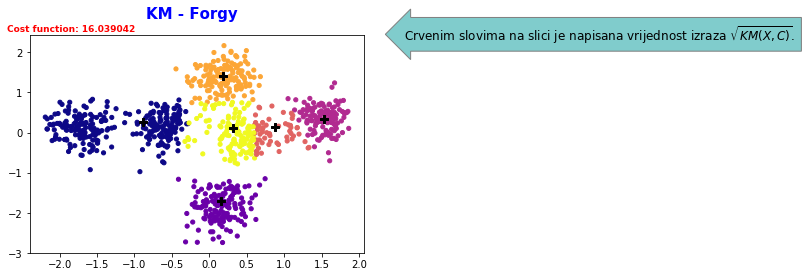

In [38]:
## Crtanje grafa

b = belong(X_np,centri_km_forgy)

plt.figure()
plt.scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
plt.scatter(centri_km_forgy[:,0], centri_km_forgy[:,1], marker='P', c='black', s=50, alpha=1)
plt.suptitle("KM - Forgy", fontsize=15, fontweight='bold', color='blue')
cost_f1 = "Cost function: " + str(round(cost1, 6))
plt.figtext(0.37, 0.895, cost_f1, fontweight='bold', horizontalalignment='right', fontsize=9, color='r')

text2 = "Crvenim slovima na slici je napisana vrijednost izraza $\sqrt{KM(X,C)}$."
plt.text(2.6, 2.3, text2, size=12, bbox=dict(boxstyle="larrow,pad=0.5", ec=(0.5, 0.5, 0.5), fc=(0.5, 0.8, 0.8) ) )

###### KM - Random Partition <a name="kmrp"></a>

In [39]:
## Pokretanje algoritma

while(True):
    stari_centri = centri_km_RP
    
    for j in range(k):
        centri_km_RP[j] = cj_km(X_np,centri_km_RP,centri_km_RP[j])

    if( np.array_equal(stari_centri, centri_km_RP) ):
        break

In [40]:
## Racunanje cost funkcije

cost2 = math.sqrt( KM(X_np,centri_km_RP) )
print("KM - RP quality: %.16f \n" %cost2)

KM - RP quality: 19.4421030423184682 



Text(0.37, 0.895, 'Cost function: 19.442103')

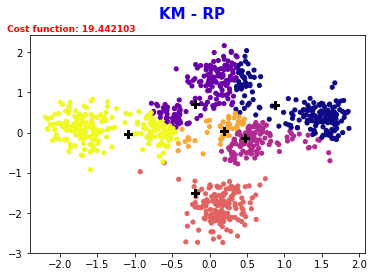

In [41]:
## Crtanje grafa

b = belong(X_np,centri_km_RP)

plt.figure()
plt.scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
plt.scatter(centri_km_RP[:,0], centri_km_RP[:,1], marker='P', c='black', s=50, alpha=1)
plt.suptitle("KM - RP", fontsize=15, fontweight='bold', color='blue')
cost_f2 = "Cost function: " + str(round(cost2, 6))
plt.figtext(0.37, 0.895, cost_f2, fontweight='bold', horizontalalignment='right', fontsize=9, color='r')

###### KHM - Forgy <a name="khmf"></a>

In [42]:
## Pokretanje algoritma

while(True):
    stari_centri = centri_khm_forgy

    for j in range(k):
        centri_khm_forgy[j] = cj_khm(X_np, centri_khm_forgy, centri_khm_forgy[j])

    if( np.array_equal(stari_centri, centri_khm_forgy) ):
        break

In [43]:
## Racunanje cost funkcije

cost3 = math.sqrt( KM(X_np,centri_khm_forgy) )
print("KHM - Forgy quality: %.16f \n" %cost3)

KHM - Forgy quality: 14.8287750139986905 



Text(0.37, 0.895, 'Cost function: 14.828775')

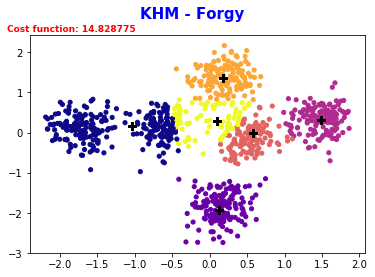

In [44]:
## Crtanje grafa

b = belong(X_np,centri_khm_forgy)

plt.figure()
plt.scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
plt.scatter(centri_khm_forgy[:,0], centri_khm_forgy[:,1], marker='P', c='black', s=50, alpha=1)
plt.suptitle("KHM - Forgy", fontsize=15, fontweight='bold', color='blue')
cost_f3 = "Cost function: " + str(round(cost3, 6))
plt.figtext(0.37, 0.895, cost_f3, fontweight='bold', horizontalalignment='right', fontsize=9, color='r')

###### KHM - Random Partition <a name="khmrp"></a>

In [45]:
## Pokretanje algoritma

while(True):
    stari_centri = centri_khm_RP

    for j in range(k):
        centri_khm_RP[j] = cj_khm(X_np, centri_khm_RP, centri_khm_RP[j])

    if( np.array_equal(stari_centri, centri_khm_RP) ):
        break

In [46]:
## Racunanje cost funkcije

cost4 = math.sqrt( KM(X_np,centri_khm_RP) )
print("KHM - RP quality: %.16f \n" %cost4)

KHM - RP quality: 37.4421885280849622 



Text(0.37, 0.895, 'Cost function: 37.442189')

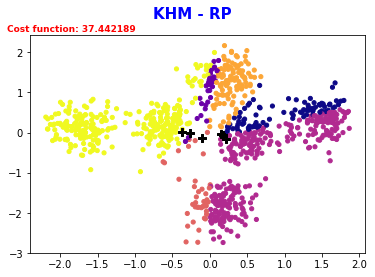

In [47]:
## Crtanje grafa

b = belong(X_np,centri_khm_RP)

plt.figure()
plt.scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
plt.scatter(centri_khm_RP[:,0], centri_khm_RP[:,1], marker='P', c='black', s=50, alpha=1)
plt.suptitle("KHM - RP", fontsize=15, fontweight='bold', color='blue')
cost_f4 = "Cost function: " + str(round(cost4, 6))
plt.figtext(0.37, 0.895, cost_f4, fontweight='bold', horizontalalignment='right', fontsize=9, color='r')

###### Prikažimo sada sve dobivene rezultate na jednom mjestu te ih usporedimo: <a name="usporedba"></a>

Text(0.5, 69.00000000000009, 'Cost function: 37.442189')

<Figure size 432x288 with 0 Axes>

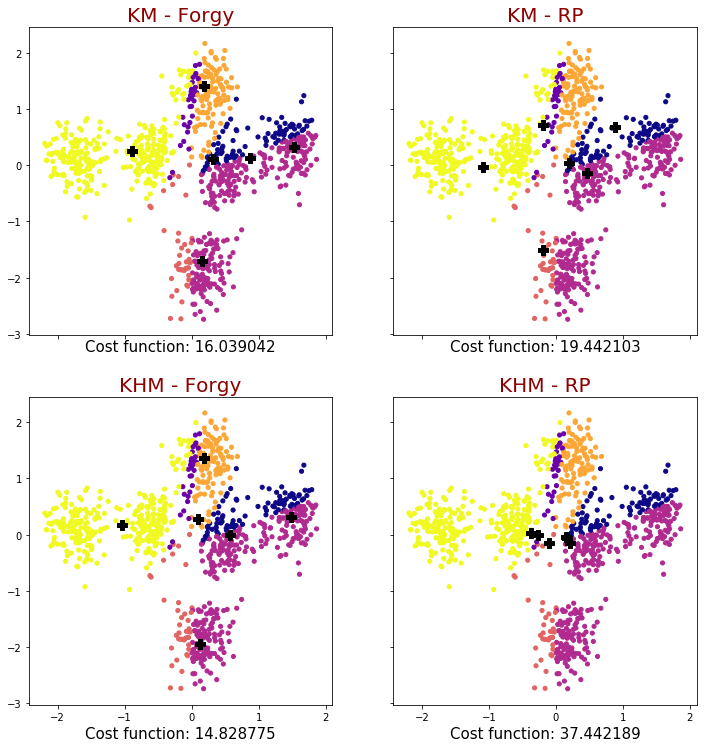

In [48]:
fig2 = plt.figure()    
fig2, axes = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize=(10,10))
fig2.tight_layout()
plt.subplots_adjust(wspace = 0.2,hspace = 0.2)

axes[0][0].scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
axes[0][0].scatter(centri_km_forgy[:,0], centri_km_forgy[:,1], marker='P', c='black', s=100, alpha=1)
axes[0][0].set_title("KM - Forgy",size=20,color='darkred')
axes[0][0].set_xlabel(cost_f1,size=15,color='black')

axes[0][1].scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
axes[0][1].scatter(centri_km_RP[:,0], centri_km_RP[:,1], marker='P', c='black', s=100, alpha=1)
axes[0][1].set_title("KM - RP",size=20,color='darkred')
axes[0][1].set_xlabel(cost_f2,size=15,color='black')

axes[1][0].scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
axes[1][0].scatter(centri_khm_forgy[:,0], centri_khm_forgy[:,1], marker='P', c='black', s=100, alpha=1)
axes[1][0].set_title("KHM - Forgy",size=20,color='darkred')
axes[1][0].set_xlabel(cost_f3,size=15,color='black')

axes[1][1].scatter(X_np[:,0], X_np[:,1], c=b, s=17, cmap="plasma")
axes[1][1].scatter(centri_khm_RP[:,0], centri_khm_RP[:,1], marker='P', c='black', s=100, alpha=1)
axes[1][1].set_title("KHM - RP",size=20,color='darkred')
axes[1][1].set_xlabel(cost_f4,size=15,color='black')

Iz slika se može primijetiti kako u Forgy inicijalizaciji cost function daje bolju ocjenu za K-Harmonic Means algoritam, nego za K-Means algoritam, dok za Random Partition inicijalizaciju vrijedi obrnuto.

Što se tiče usporedbe inicijalizacija, Forgy bolje minimizira cost function, nego li to radi Random Partition.

Uvjerljivo najgore rezultate je dao KHM algoritam u kombinaciji s RP inicijalizacijom. Osim što vidimo lošu vrijednost cost funkcije, vidimo i da se KHM ipak muči sa "razvlačenjem" svojih centara prema centroidima svojih grupa, iako je njegova weight funkcija "dizajnirana" tako da mu u tome pomogne. 

###### Prosječno ponašanje <a name="prosjecno"></a>

Kako ne bismo donijeli zaključke nakon samo jednog provedenog testa (jer inicijalizacije centara se ipak svakim pokretanjem programa mijenjaju te tako mijenjaju i rezultate algoritama), pokrenimo sada sve 4 verzije algoritma po 10 puta kako bismo analizirali i donijeli zaključke na temelju prosječnog ponašanja. Kriterij usporedbe će nam naravno i dalje biti $\sqrt{KM(X,C)}$.

Naime, čak i za broj 10 je izvršavanje sljedeće ćelije sporo (~4-5min) pa nećemo testirati za veći broj.

In [49]:
## Ponovna inicijalizacija centara kako se nebi koristili prijasnji, vec namjesteni
centri_km_forgy = Forgy_initialization(X_np,k)
centri_khm_forgy = centri_km_forgy.copy()

centri_km_RP = RP_initialization(X_np,k)
centri_khm_RP = centri_km_RP.copy()


## Cost funkcije kao kriterij usporedbe
cost11 = 0
cost22 = 0
cost33 = 0
cost44 = 0


## Mjerimo vrijeme za izvođenje
start = time.time()


## Svaki algoritam pokrecemo 10 puta
for i in range(10):

    ## KM - Forgy
    while(True):
        stari_centri = centri_km_forgy

        for j in range(k):
            centri_km_forgy[j] = cj_km(X_np,centri_km_forgy,centri_km_forgy[j])

        if( np.array_equal(stari_centri, centri_km_forgy) ):
            break
            
    cost11 += math.sqrt( KM(X_np,centri_km_forgy) )
    
    ## KM - RP
    while(True):
        stari_centri = centri_km_RP

        for j in range(k):
            centri_km_RP[j] = cj_km(X_np,centri_km_RP,centri_km_RP[j])

        if( np.array_equal(stari_centri, centri_km_RP) ):
            break
            
    cost22 += math.sqrt( KM(X_np,centri_km_RP) )
    
    ## KHM - Forgy
    while(True):
        stari_centri = centri_khm_forgy

        for j in range(k):
            centri_khm_forgy[j] = cj_khm(X_np,centri_khm_forgy,centri_khm_forgy[j])

        if( np.array_equal(stari_centri, centri_khm_forgy) ):
            break
            
    cost33 += math.sqrt( KM(X_np,centri_khm_forgy) )
    
    ## KHM - RP
    while(True):
        stari_centri = centri_khm_RP

        for j in range(k):
            centri_khm_RP[j] = cj_khm(X_np,centri_khm_RP,centri_khm_RP[j])

        if( np.array_equal(stari_centri, centri_khm_RP) ):
            break
            
    cost44 += math.sqrt( KM(X_np,centri_khm_RP) )

    
end = time.time()

cost11 = cost11/10
cost22 = cost22/10
cost33 = cost33/10
cost44 = cost44/10

In [50]:
print("Vrijeme izvođenja sva 4 algoritma po 10 puta (u sekundama): ")
print(end - start)

Vrijeme izvođenja sva 4 algoritma po 10 puta (u sekundama): 
258.4707112312317


In [53]:
prosjek = {'KM-Forgy' : cost11, 'KM-RP' : cost22, 'KHM-Forgy' : cost33, 'KHM-RP' : cost44}
prosjek

{'KM-Forgy': 12.258403679426834,
 'KM-RP': 12.8997427119821,
 'KHM-Forgy': 12.15687128107967,
 'KHM-RP': 16.15831877341316}

### ZAKLJUČAK <a name="zakljucak"></a>

Zaključci na temelju prosječnog ponašanja su doneseni na nekoliko uzastopnih pokretanja gornje "spore ćelije" i oni su sljedeći:
- uspoređujući inicijalizacije, Forgy inicijalizacija je bolji preduvjet za oba algoritma, tj. algoritmi čiji su centri početno "pogođeni" Forgy metodom, bolje optimiziraju funkciju cilja
- uspoređujući same algoritme, iz ovoga možemo zaključiti da rezultati usporedbe ipak ovise o inicijalizaciji i ne možemo izabrati jednog od njih kao apsolutnog pobjednika: s Forgyijem rezultati usporedbe variraju, dok će se s RP uvijek boljim pokazati KM, nego KHM

Zaključci doneseni ispod grafova nakon provođenja jednog testa su većinom točni te ti grafovi ne odudaraju puno od prosjeka. Jedina činjenica koja varira je usporedba KM-a i KHM-a inicijaliziranih s Forgyijem. Podjednako mnogo puta pobijede i jedan i drugi i većinom su im vrijednosti cost function-a vrlo blizu. <u>Blagu</u> prednost ima KM.

KHM s RP-om se uvijek predstavi kao najgora kombinacija.

Također, algoritam (dakle, ovo vrijedi i za KM i za KHM) s Forgy inicijalizacijom ima tendenciju više povući centre u centroid svoje grupe, za razliku od algoritma inicijaliziranog s Random Partition inicijalizacijom koji, zbog težinskih funkcija točaka, očito ne uspije dovoljno povući centar u središte grupe. 

Gledajući baš sve 4 verzije u prosjecima, te ako pojedinačno gledamo s jedne strane KM (s obje inicijalizacije) i s druge strane KHM (s obje inicijalizacije) - prednost dobiva KM algoritam. Stoga ovo istraživanje pokazuje da hard membership i konstantna weight function više pridonose optimalnom rješenju nego hard membership i varirajuća weight function. 

### DODATAK <a name="dodatak"></a>

Vizualni prikaz jednog idealnog grupiranja u 3D. Funkcijom *make_blobs* ćemo izgenerirati skup X_3D od random 100 trodimenzionalnih podataka. *Make_blobs* ih izgenerira tako da su oni prirodno već raspoređeni po grupama. Funkciji ćemo zadati da ih rasporedi u 3 grupe. Funkcija će nam, osim skupa X_3D, vratiti i skup Y_3D koji za svaki od 100 podataka čuva indeks grupe kojem pripada.

In [54]:
# Paketi i funkcije potrebne za vizualni prikaz u 3D

# Potrebno skinuti paket plotly (Komanda u terminalu: conda install -c https://conda.anaconda.org/plotly plotly)

from sklearn.datasets import make_blobs
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode()

In [55]:
# Generiranje i sređivanje podataka
X_3D, Y_3D = make_blobs(n_samples=100,n_features=3,centers=3,cluster_std=2.5)

# Za ljepšu vizualizaciju podataka, prikazat ćemo ih tablično
tablica = pd.DataFrame(X_3D)

# Promijenimo imena stupaca u x0, x1, x2
tablica.columns = ['x' + str(i) for i in tablica.columns]

# I dodajmo stupac y
tablica['y'] = Y_3D

tablica.head()

x0        x1        x2  y
0 -2.511536 -5.400586  4.777891  2
1 -0.053982 -8.142479  2.984827  2
2 -7.752122  2.125070 -4.451064  0
3  8.265287 -4.753711  3.750217  1
4  7.259584 -7.819918  4.879760  1

In [62]:
# Crtanje interaktivnog 3D grafa

# U grupe spremamo sve podatke koje im pripadaju
grupa1 = tablica.loc[tablica['y'] == 0]
grupa2 = tablica.loc[tablica['y'] == 1]
grupa3 = tablica.loc[tablica['y'] == 2]

# Bojanje tocaka
tocke1 = dict(
    mode = "markers",
    name = "Grupa 1",
    type = "scatter3d",    
    x = grupa1.values[:,0], y = grupa1.values[:,1], z = grupa1.values[:,2],
    marker = dict( size=2, color='green')
)
tocke2 = dict(
    mode = "markers",
    name = "Grupa 2",
    type = "scatter3d",    
    x = grupa2.values[:,0], y = grupa2.values[:,1], z = grupa2.values[:,2],
    marker = dict( size=2, color='blue')
)
tocke3 = dict(
    mode = "markers",
    name = "Grupa 3",
    type = "scatter3d",    
    x = grupa3.values[:,0], y = grupa3.values[:,1], z = grupa3.values[:,2],
    marker = dict( size=2, color='red')
)

# Bojanje povrsine obuhvacene grupom
povrsina1 = dict(
    alphahull = 4, # Za ljepsi oblik povrsine
    name = "Grupa 1",
    opacity = 0.2,
    type = "mesh3d",    
    x = grupa1.values[:,0], y = grupa1.values[:,1], z = grupa1.values[:,2],
    color='green'
)
povrsina2 = dict(
    alphahull = 4,
    name = "Grupa 2",
    opacity = 0.2,
    type = "mesh3d",    
    x = grupa2.values[:,0], y = grupa2.values[:,1], z = grupa2.values[:,2],
    color='blue'
)
povrsina3 = dict(
    alphahull = 4,
    name = "Grupa 3",
    opacity = 0.2,
    type = "mesh3d",    
    x = grupa3.values[:,0], y = grupa3.values[:,1], z = grupa3.values[:,2],
    color='red'
)

# Crtanje 
fig = dict( data=[tocke1, tocke2, tocke3, povrsina1, povrsina2, povrsina3] )
plotly.offline.iplot(fig)

A kako primijeniti K-Means i grupiranja na n-dimenzionalne podatke za $n>3$, tj. kako to vizualizirati? Pristup je sljedeći.
Podijelit ćemo podatke u k grupa po K-Means kriteriju te zatim izračunati zbroj svake dimenzije pojedinačno (za svaku grupu). Potom dobivene podatke crtamo u *heat map*-u$^2$.

Postupak:
Izgenerirat ćemo ponovno jedan skup s *make_blobs* funkcijom. Konstruirat ćemo 100 10-dimenzionalnih podataka koji su grupirani u 4 grupe. Na primjer, time simuliramo bazu podataka o klijentima jedne velike banke. Za svakog klijenta ona čuva 10 različitih karakteristika/svojstava, na primjer klijentova plaća, stanje na računu, krediti, itd. Crtanjem K-Means grupa i dimenzija/svojstava u *heat map*-u ilustriramo kako velika banka može iskoristiti strojno učenje za kategoriziranje svojih klijenata u razne primjene poput marketinga ili ponude svojih usluga.

$^2$ *Heat map je grafička reprezentacija podataka gdje su vrijednosti u matrici reprezentirane kao boje.*

In [57]:
# Generiranje podataka
X_nD, Y_nD = make_blobs(n_samples=100,n_features=10,centers=4,cluster_std=100)

# Spremamo podatke u Pandas DataFrame
tablica2 = pd.DataFrame(X_nD)

# Uzimamo samo pozitivne vrijednosti (ako je vec simulacija banke u pitanju, ovo je realisticnije)
tablica2 = tablica2.abs()

# Promijenimo ime stupaca u x0,x1,...,x10
tablica2.columns = ['x' + str(i) for i in tablica2.columns]

# Dodajmo stupac y
tablica2['y'] = Y_nD

# Podijelimo tablicu u grupe
grupe = tablica2.groupby(['y'], sort=True)

# Izracunajmo sume za svaki stupac u svakoj grupi
zbroj = grupe.sum()

zbroj

x0           x1           x2           x3           x4  \
y                                                                    
0  1545.346714  2020.903856  2156.071547  1829.565087  1319.480920   
1  1713.411449  2296.284994  1892.422960  2275.302783  2181.081420   
2  1571.608213  2059.432984  1683.521343  2115.019565  1963.788850   
3  1755.193160  2131.236592  1864.270971  1856.967835  1948.898458   

            x5           x6           x7           x8           x9  
y                                                                   
0  2535.496198  1930.646571  1507.253605  1605.290042  2139.723199  
1  2248.241138  1925.131796  2618.490020  2316.950836  1739.934557  
2  2010.501066  2203.661118  1803.737330  2494.006638  1606.760735  
3  2000.211303  2127.161476  1812.035755  1939.240849  1988.940389

In [66]:
# Crtanje heat map-a

# Bojanje
grupiranje = [go.Heatmap( 
                   z=zbroj.values.tolist(), 
                   y=['Grupa A', 'Grupa B', 'Grupa C', 'Grupa D'],
                   x=['Primanja',
                      'Iznos štednje',
                      'Debitna kartica',
                      'Privatna kreditna kartica',
                      'Poslovna kreditna kartica',
                      'Kredit za nekretnine',
                      'Kredit za auto',
                      'Zdravstveno osiguranje',
                      'Osiguranje za automobil',
                      'Životno osiguranje'
                     ]   )]

# Crtanje
plotly.offline.iplot(grupiranje)

### LITERATURA <a name="literatura"></a>

[1]  Greg Hamerly, Charles Elkan: *Alternatives to the K-means Algorithm That Find Better Clusterings*. Department of Computer Science and Engineering, University of California, 2002.

[2] www.learnpython.org

[3] www.stackoverflow.com